# 1. Classification

Presentation of some algorithms. We will here use some classifiers commonly used. The classifiers we compare here are the following :
- [The K-Nearest Neighbors (KNN) Classifier](#1.1-K-Nearest-Neighbors)
- [Support Vector Machine (SVM)](#1.2-Support-Vector-Machine)
- [Gaussian Process Classifier](#1.3-Gaussian-Process-Classifier)
- [Decision Tree Classifier](#1.4-Decision-Tree-Classifier)
- [Random Forest Classifier](#1.5-Random-Forest-Classifier)
- [The Ada Boost Classifier](#1.6-Ada-Boost-Classifier)
- [Naive Bayes Classifier](#1.7-Naive-Bayes-Classifier)


## 1.1 K-Nearest Neighbors
...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from lblearn.datasets import load_galaxies

In [ ]:
galaxies = load_galaxies(n_samples=150)  # 150 of each species
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = KNeighborsClassifier(3)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(accuracy_score(y_pred=predictions, y_true=y_test))
print(np.sum(predictions == y_test)/len(y_test))

The accuracy is better than random, but is still poor. To improve it, we can try to change some hyperparameters, such as the number of neighbor. Before doing so, we first try to scale the data. Indeed, the column `NVOTE`has large values whereas all the others are probabilities ranging from 0 to 1.  

In [ ]:
galaxies = load_galaxies(n_samples=150)  # 150 of each species
X, y = galaxies.data, galaxies.target

scaler = MinMaxScaler()
scaler_test = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler.fit(X_train[:, 0].reshape(-1, 1))  
X_train[:, 0] = scaler.transform(X_train[:, 0].reshape(-1, 1)).flatten()  # All data is between 0 and 1 but NVOTE
scaler_test.fit(X_test[:, 0].reshape(-1, 1))  
X_test[:, 0] = scaler_test.transform(X_test[:, 0].reshape(-1, 1)).flatten()

model = KNeighborsClassifier(7)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

score = accuracy_score(y_pred=predictions, y_true=y_test)
print(score)
print(np.sum(predictions == y_test)/len(y_test))

The accuracy score is a precious indicator on the performance of our model. However it does not indicate where the model has gone wrong. A good alternative to it is the confusion matrix:

In [ ]:
print(confusion_matrix(y_test, predictions))
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"KNN, accuracy ={score: .2f}");

Sklearn also implements grid search methods to find the best set of parameters for our model:

In [ ]:
galaxies = load_galaxies(n_samples=150)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


pipe = Pipeline([('scale', MinMaxScaler()), ('clf', KNeighborsClassifier())])

param_grid = {"clf__n_neighbors":list(range(1, 15)), "clf__metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]} 

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1, n_jobs=-1)

# fitting the model for grid search
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_, ":", grid_search.best_score_)

Altough the sklearn API is nicely designed and quite intuitive, adding all these steps can become quite tedious. This is particularly true when changing the type of classifier, all the lines have to be rewritten. Luckily enough, sklearn provide a nice way to overcome this difficulty: the pipelines

In [ ]:
galaxies = load_galaxies(n_samples=300)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = KNeighborsClassifier(3, metric='euclidean')
clf = make_pipeline(MinMaxScaler(), classifier)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)

disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"KNN, accuracy ={score: .2f}")
plt.savefig("plots/KNN_cm.jpg");

## 1.2 Support Vector Machine

Les machines à vecteurs de support (SVM) sont une famille d'algorithmes d'apprentissage supervisé utilisée pour la classification et la régression. L'objectif des SVM est de trouver une frontière de décision optimale, appelée hyperplan, qui sépare les différentes classes d'échantillons de données en maximisant la marge, c'est-à-dire la distance entre les échantillons les plus proches de chaque classe. Cette approche est particulièrement utile pour les jeux de données avec des caractéristiques complexes et non linéaires, où une simple frontière de décision linéaire ne suffit pas à séparer efficacement les classes. Les SVM peuvent également être utilisées pour des jeux de données de petite et moyenne taille, mais ne sont pas recommandées pour des jeux de données très volumineux car elles peuvent être assez gourmandes en ressources.

Les SVM disposent de plusieurs paramètres importants qui doivent être ajustés pour obtenir les meilleures performances pour un jeu de données donné. Parmi ces paramètres, on peut citer le choix de la fonction noyau (par exemple, linéaire, polynomial ou fonction de base radiale (RBF)), la régularisation C et le gamma. La fonction noyau est utilisée pour transformer les données d'entrée en un espace de dimension supérieure où les classes sont plus facilement séparables. Les noyaux les plus couramment utilisés sont les noyaux linéaires, polynomiaux et radiaux. Les noyaux linéaires sont utilisés pour les données linéairement séparables, tandis que les noyaux polynomiaux et radiaux sont utilisés pour les données non linéaires. Le choix de la fonction noyau dépend de la nature des données d’entrée.

Le paramètre de régularisation C contrôle le compromis entre la maximisation de la marge et la minimisation de l'erreur. Les valeurs de C plus élevées entraînent des marges plus étroites et une classification plus précise des points de données d'entraînement, mais peuvent également entraîner un sur-ajustement. Les valeurs de C plus faibles permettent des marges plus larges et une classification moins précise des points de données d'entraînement, mais peuvent également réduire le sur-ajustement.

Le paramètre gamma est le coefficient du noyau RBF. Ce paramètre affecte la forme des frontières de décision. Les valeurs de gamma plus élevées entraînent des frontières de décision plus complexes, qui peuvent conduire à un sur-ajustement. Les valeurs de gamma plus faibles entraînent des frontières de décision plus lisses, qui peuvent conduire à une sous-ajustement.

In [ ]:
from sklearn.svm import SVC

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

pipe = Pipeline([('scale', MinMaxScaler()), ('clf', SVC())])


param_grid = [
  {'clf__C': [1, 10, 100, 1000, 1500, 10_000], 'clf__kernel': ['linear']},
  {'clf__C': [1, 10, 100, 1000, 1500, 10_000], 'clf__gamma': [0.001, 0.0001], 'clf__kernel': ['rbf']},
 ] 

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1)

# fitting the model for grid search
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_, ":", grid_search.best_score_)

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = SVC(kernel='linear', C=1000)
clf = make_pipeline(MinMaxScaler(), classifier)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"SVC, accuracy ={score: .2f}")
plt.savefig("plots/SVM_cm.jpg");

## 1.3 Gaussian Process Classifier
...

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = MinMaxScaler()
scaler_test = MinMaxScaler()

scaler.fit(X_train[:, 0].reshape(-1, 1))  
X_train[:, 0] = scaler.transform(X_train[:, 0].reshape(-1, 1)).flatten()  # All data is between 0 and 1 but NVOTE
scaler_test.fit(X_test[:, 0].reshape(-1, 1))  
X_test[:, 0] = scaler_test.transform(X_test[:, 0].reshape(-1, 1)).flatten()

classifier = GaussianProcessClassifier()

param_grid = [{
    "kernel": [RBF(l) for l in np.logspace(-1, 1, 10)]
}, {
    "kernel": [DotProduct(sigma_0) for sigma_0 in np.logspace(-1, 1, 10)]
}]

grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1)

# fitting the model for grid search
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_, ":", grid_search.best_score_)

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = GaussianProcessClassifier(DotProduct(0.1))
clf = make_pipeline(MinMaxScaler(), classifier)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test, predictions))
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"Gaussian process, accuracy ={score: .2f}");

## 1.4 Decision Tree Classifier
...

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [19]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


pipe = Pipeline([('scale', MinMaxScaler()), ('clf', DecisionTreeClassifier())])

classifier = DecisionTreeClassifier()

param_grid = [
    {'criterion': ['entropy', 'gini', 'log_loss'], 'max_depth': list(range(5, 30))}
             ]

grid = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1)

# fitting the model for grid search
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_, ":", grid_search.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'criterion': 'entropy', 'max_depth': 19} : 0.819047619047619


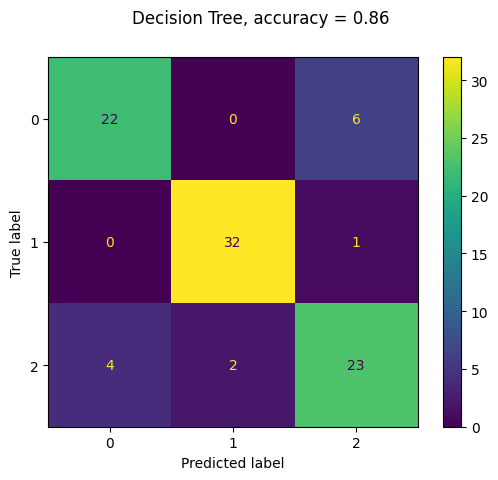

In [25]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = DecisionTreeClassifier(criterion='log_loss', max_depth=14)

classifier.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"Decision Tree, accuracy ={score: .2f}");

In [29]:
dot_data = export_graphviz(classifier, out_file=None, 
                           feature_names=galaxies.feature_names,  
                           class_names=galaxies.target_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Afficher l'arbre dans Jupyter Notebook ou dans un IDE
graph = graphviz.Source(dot_data)
graph.render("arbre_decision")

# Sauvegarder l'arbre au format PDF
graph.format = 'pdf'
graph.render("arbre_decision")

'arbre_decision.pdf'

## 1.5 Random Forest Classifier
...

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = MinMaxScaler()
scaler_test = MinMaxScaler()

scaler.fit(X_train[:, 0].reshape(-1, 1))  
X_train[:, 0] = scaler.transform(X_train[:, 0].reshape(-1, 1)).flatten()  # All data is between 0 and 1 but NVOTE
scaler_test.fit(X_test[:, 0].reshape(-1, 1))  
X_test[:, 0] = scaler_test.transform(X_test[:, 0].reshape(-1, 1)).flatten()

classifier = RandomForestClassifier()

param_grid = [
    {'criterion': ['entropy', 'gini', 'log_loss'], 'max_depth': list(range(20, 40)),
     'n_estimators' : [20, 30]
    }
             ]

grid = GridSearchCV(classifier, param_grid, cv=10, scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1)

# fitting the model for grid search
grid_search = grid.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=34)
clf = make_pipeline(MinMaxScaler(), classifier)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"Random Forest, accuracy ={score: .2f}");

## 1.6 Perceptron

Le perceptron est un algorithme de classification binaire linéaire qui apprend un
hyperplan séparateur pour séparer les données en deux classes. Il est basé sur une fonction
d'activation en escalier qui prend la somme pondérée des entrées et retourne une sortie
binaire. Le modèle est entraîné en ajustant les poids des entrées pour minimiser l'erreur de
classification.
Le perceptron est le plus efficace lorsque les données sont linéairement séparables,
c'est-à-dire lorsque les deux classes peuvent être séparées par un hyperplan. Il a été l'un
des premiers algorithmes d'apprentissage automatique à être développé et est souvent
utilisé comme base pour des modèles plus complexes comme les réseaux de neurones. Il
est également utilisé pour la classification en temps réel et l'apprentissage en ligne. Le
perceptron est à la base un algorithme binaire, donc il est plus naturellement utilisé pour
des problèmes de classification binaire. Cependant, il est possible de l'étendre à plusieurs
classes en utilisant des techniques de "one-vs-all" ou "one-vs-one". Dans le premier cas,
on entraine $K$ perceptrons binaires, chacun distinguant une classe des autres, et dans le
deuxième cas, on entraine $K(K-1)/2$ perceptrons binaires, chacun distinguant deux classes
à la fois.
Donc, même si le perceptron est plus efficace pour des problèmes de classification
binaire, il est toujours possible de l'utiliser pour des problèmes multi-classe en adaptant
l’algorithme.

In [2]:
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

In [3]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

param_grid = [{
    'clf__tol': [1e-1, 1e-3, 1e-5],
    'clf__penalty': ['l2', 'l1', 'elasticnet'],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
    'clf__eta0': [1e-4, 1e-3, 1e-2, 1e-1, 1]
}]


pipe = Pipeline([('scale', MinMaxScaler()), ('clf', Perceptron())])

grid = GridSearchCV(pipe, param_grid,scoring='accuracy', cv=5, return_train_score=True, verbose=1, n_jobs=-1)

grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_, ":", grid_search.best_score_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
{'clf__alpha': 0.001, 'clf__eta0': 0.01, 'clf__penalty': 'l1', 'clf__tol': 1e-05} : 0.819047619047619


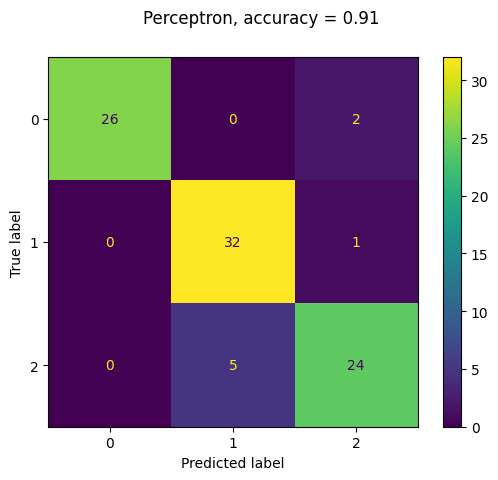

In [4]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = Perceptron(alpha=0.001, eta0=0.01, penalty='l1', tol=1e-5)
clf = make_pipeline(MinMaxScaler(), classifier)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"Perceptron, accuracy ={score: .2f}")
plt.savefig("plots/Perceptron_cm.jpg");

## 1.8 Ada Boost Classifier
...

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

pipe = Pipeline([('scale', StandardScaler()), ('clf', AdaBoostClassifier(estimator=DecisionTreeClassifier()))])

param_grid = {'clf__estimator__max_depth':list(range(1, 30)),
              'clf__estimator__criterion':['entropy', 'gini', 'log_loss'],
              'clf__n_estimators':[10, 50, 250, 1000],
              'clf__learning_rate':[0.01, 0.1]} 


grid = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=5, return_train_score=True, verbose=1, n_jobs=-1)

grid_search = grid.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3), learning_rate=0.1, n_estimators=250)
clf = make_pipeline(MinMaxScaler(), classifier)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test, predictions))
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"AdaBoost, accuracy ={score: .2f}");

## 1.9  Multi Layer Perceptron 

...

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
galaxies = load_galaxies(n_samples=10000)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('mlp', MLPClassifier())
])

# Définition des paramètres pour la recherche de grille
parameters = {
    'mlp__hidden_layer_sizes': [(32, 32), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__max_iter': [3000, 4000, 5000]
}

# Création de l'estimateur GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, scoring='accuracy', cv=2, return_train_score=True, verbose=3, n_jobs=-1)

# Entrainement sur les données
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et score
print("Meilleurs paramètres: ", grid_search.best_params_)
print("Score de la meilleure configuration: ", grid_search.best_score_)

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifier = AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', max_depth=3), learning_rate=0.1, n_estimators=250)
clf = make_pipeline(MinMaxScaler(), classifier)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = accuracy_score(y_test, predictions)
print(confusion_matrix(y_test, predictions))
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
disp.figure_.suptitle(f"AdaBoost, accuracy ={score: .2f}");

## 1.10 Naive Bayes Classifier

Les méthodes naïves bayésiennes sont un ensemble d’algorithmes d’apprentissage supervisé qui sont basés sur l’application du théorème de Bayes. Ce théorème permet de calculer la probabilité conditionnelle d'un événement A sachant un événement B, à partir de la probabilité conditionnelle de B sachant A et des probabilités marginales de A et B. Le théorème de Bayes s'écrit ainsi :

\begin{equation}
    P(A \mid B) = \frac{P(B \mid A) \times P(A)}{P(B)}
    \label{eq:bayes-theorem}
\end{equation}


Les méthodes naïves bayésiennes font l'hypothèse d'indépendance conditionnelle entre chaque paire de caractéristiques, étant donné la valeur de la variable appartenant à la classe. Cela se traduit mathématiquement par la modification suivante du théorème de Bayes :

\begin{equation}
    P(y|x_1,...,x_n) = \frac{P(y)\prod_{i=1}^nP(x_i|y)}{P(x_1,...,x_n)}
    \label{eq:naive-bayes-theorem}
\end{equation}

Cette formule est la base de tous les classificateurs naïfs bayésiens. La seule différence entre ces classificateurs réside dans la distribution $P(x_i | y)$, c’est-à-dire la probabilité que $x_i$ correspondant à la classe $y$. Ce type de classificateur fonctionne bien pour la classification de documents ou le filtrage des pourriels, par exemple. Les classificateurs naïfs bayésiens ont de nombreux avantages tels que le peu de données d’entraînement nécessaire, la vitesse ou l’insensibilité au fléau de la dimension. Néanmoins, bien que ce soient de bons classificateurs, ils s’avèrent être de mauvais estimateurs.

Parmi les lois de probabilités pour $P(x_i | y)$, on trouve notamment la loi normale, la loi de Bernoulli et la loi multinomiale. Le classificateur naïf bayésien gaussien utilise une loi normale pour modéliser la distribution de chaque caractéristique $x_i$ pour chaque classe $y$. Les paramètres de la loi normale (moyenne et écart-type) sont estimés à partir des données d'entraînement. Parmi les classificateurs naïfs bayésiens on trouve :

- Classificateur naïf bayésien gaussien
- Classificateur naïf bayésien de Bernoulli
- Classificateur naïf bayésien multinomial


En utilisant les méthodes naïves bayésiennes, nous pouvons donc construire des modèles de classification efficaces pour des problèmes avec des caractéristiques discrètes ou continues. Le choix de la distribution appropriée dépendra des caractéristiques des données et des hypothèses que nous faisons sur leur distribution. Pour déterminer quel classificateurs correspond le mieux à notre problème, nous les introduisons succinctement dans les parties suivantes.

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB

In [ ]:
galaxies = load_galaxies(n_samples=100)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()] #, CategoricalNB()]


for classifier in classifiers:
    # pipeline = Pipeline([('scale', MinMaxScaler()), ('clf', classifier)])
    # clf = make_pipeline(MinMaxScaler(), classifier)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    score = accuracy_score(y_test, predictions)
    # print(confusion_matrix(y_test, predictions))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    disp.figure_.suptitle(f"{classifier.__class__.__name__}, accuracy ={score: .2f}")
    plt.savefig(f"plots/{classifier.__class__.__name__}.jpg");

## Automated research

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

In [ ]:
from lblearn.datasets import load_galaxies

galaxies = load_galaxies(n_samples=150)
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
dataset = {}
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    # disp = ConfusionMatrixDisplay.from_predictions
    cm = confusion_matrix(y_test, predicted)

# For each cell in the confusion matrix, add the corresponding ground truths
# and predictions to the lists
    y_true = []
    y_pred = []
    for gt in range(len(cm)):
        for pred in range(len(cm)):
            y_true += [gt] * cm[gt][pred]
            y_pred += [pred] * cm[gt][pred]

    print(
        f"Classification report rebuilt from confusion matrix for {name}:\n"
        f"{classification_report(y_true, y_pred)}\n"
    )
    score = accuracy_score(y_test, y_pred)
    dataset[name] = score

In [ ]:
dataset = dict(reversed(sorted(dataset.items(), key=lambda item: item[1])))

In [ ]:
import pandas as pd
from IPython.display import display, HTML
# Créer un dataframe de test
#df = pd.DataFrame({'Nom': ['Alice', 'Bob', 'Charlie'], 'Age': [25, 30, 35]})
df_scores = pd.DataFrame(dataset.items(), columns=['Algorithm', 'Score'])
# Afficher le dataframe en Markdown
df_scores

In [ ]:
# preprocess dataset, split into training and test part
X, y = galaxies.data, galaxies.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    #print(f"Confusion matrix:\n{disp.confusion_matrix}")
    disp.figure_.suptitle(f"{name}, accuracy={score: .2f}");
    #plt.imshow(confusion_matrix(y_test, y_pred),cmap='Blues', interpolation='nearest')
    #plt.grid(False)
    #plt.ylabel('True')
    #plt.xlabel('Predicted');

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix,[11] is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa – both variants are found in the literature.[12] The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another).

It is a special kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table).